<a href="https://colab.research.google.com/github/aryan-mishra219/kinetics_datathon/blob/main/team_kinetics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Saving product_sales_data.csv to product_sales_data.csv
--- Category Revenue ---
category
Electronics    8.343167e+09
Fashion        1.384031e+09
Home           3.978535e+08
Sports         2.436993e+08
Beauty         9.052204e+07
Name: revenue, dtype: float64
Percentage of total revenue from top 2 categories: 93.00%

--- Seasonal Patterns ---
Highest Month: 12, Lowest Month: 2
Growth from Lowest to Highest Month: 92.31%

--- Review Rating Impact ---
rating_bin
(2.5, 2.75]           NaN
(2.75, 3.0]     92.869565
(3.0, 3.25]     76.084034
(3.25, 3.5]     73.512605
(3.5, 3.75]    203.380895
(3.75, 4.0]    212.064909
(4.0, 4.25]    299.402067
(4.25, 4.5]    298.967297
(4.5, 4.75]    300.413064
(4.75, 5.0]    315.725989
(5.0, 5.25]           NaN
Name: units_sold, dtype: float64


/tmp/ipython-input-3749581645.py:33: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rating_impact = df.groupby('rating_bin')['units_sold'].mean()
/tmp/ipython-input-3749581645.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=rating_impact.index.astype(str), y=rating_impact.values, palette='viridis')


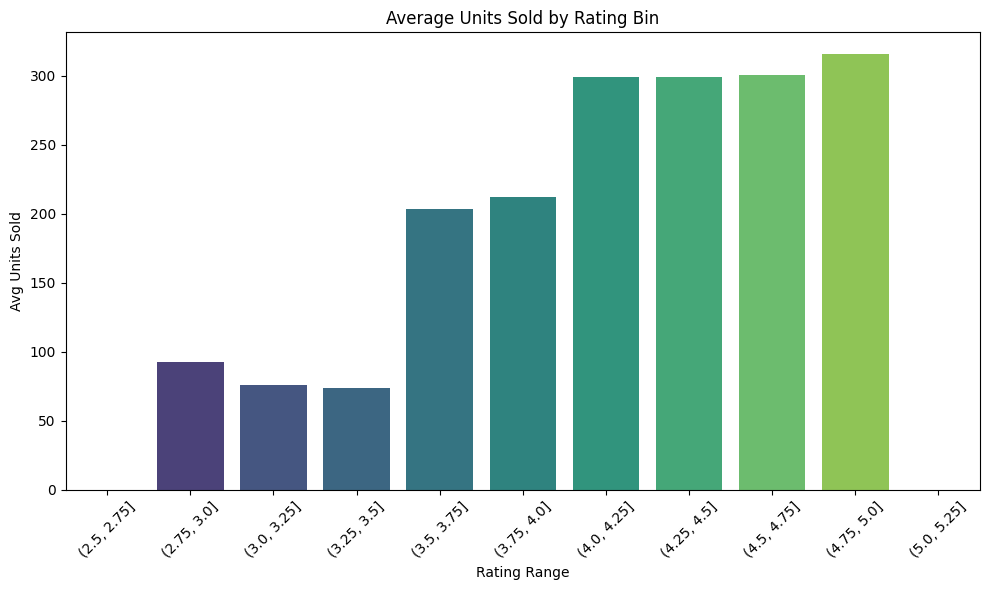


--- Promotion Impact ---
Overall Promo Increase in Units Sold: 13.94%
is_promoted  perc_increase
category                  
Sports           18.773123
Fashion          15.771286
Electronics      12.220038
Home             10.107712
Beauty            9.071797


In [ ]:
from google.colab import files
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import io

uploaded = files.upload()
df = pd.read_csv(io.BytesIO(uploaded['product_sales_data.csv']))

category_revenue = df.groupby('category')['revenue'].sum().sort_values(ascending=False)
total_revenue = category_revenue.sum()
top_2_revenue = category_revenue.head(2).sum()
percentage_top_2 = (top_2_revenue / total_revenue) * 100

print("--- Category Revenue ---")
print(category_revenue)
print(f"Percentage of total revenue from top 2 categories: {percentage_top_2:.2f}%")

monthly_sales = df.groupby('month')['revenue'].sum()
highest_month = monthly_sales.idxmax()
lowest_month = monthly_sales.idxmin()
seasonal_sales = df.groupby('season')['revenue'].sum().sort_values(ascending=False)

diff_high_low = monthly_sales.max() - monthly_sales.min()
perc_diff = (diff_high_low / monthly_sales.min()) * 100

print("\n--- Seasonal Patterns ---")
print(f"Highest Month: {highest_month}, Lowest Month: {lowest_month}")
print(f"Growth from Lowest to Highest Month: {perc_diff:.2f}%")

df['rating_bin'] = pd.cut(df['rating'], bins=np.arange(2.5, 5.5, 0.25))
rating_impact = df.groupby('rating_bin')['units_sold'].mean()

print("\n--- Review Rating Impact ---")
print(rating_impact)

plt.figure(figsize=(10, 6))
sns.barplot(x=rating_impact.index.astype(str), y=rating_impact.values, palette='viridis')
plt.title('Average Units Sold by Rating Bin')
plt.xlabel('Rating Range')
plt.ylabel('Avg Units Sold')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

overall_promo = df.groupby('is_promoted')['units_sold'].mean()
promo_increase = ((overall_promo[1] - overall_promo[0]) / overall_promo[0]) * 100

category_promo = df.groupby(['category', 'is_promoted'])['units_sold'].mean().unstack()
category_promo['perc_increase'] = ((category_promo[1] - category_promo[0]) / category_promo[0]) * 100

print("\n--- Promotion Impact ---")
print(f"Overall Promo Increase in Units Sold: {promo_increase:.2f}%")
print(category_promo[['perc_increase']].sort_values(by='perc_increase', ascending=False))

--- Ultimate Stacked Accuracy: 96.58% ---


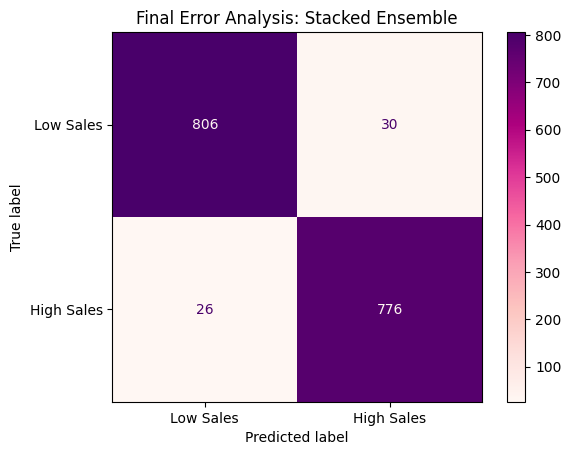

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import StackingClassifier, RandomForestClassifier, HistGradientBoostingClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

# 1. Robust Data Preparation
# We ensure all features are created within this cell to prevent errors
df_final = df.copy()
le = LabelEncoder()
df_final['category_encoded'] = le.fit_transform(df_final['category'])

# Target Definition
median_val = df_final['units_sold'].median()
df_final['sales_performance'] = (df_final['units_sold'] > median_val).astype(int)

# Advanced Feature Engineering (The "Secret Sauce")
df_final['price_to_competitor_ratio'] = df_final['price'] / (df_final['competitor_price'] + 1)
df_final['value_score'] = df_final['rating'] * np.log1p(df_final['review_count'])
df_final['promo_intensity'] = df_final['is_promoted'] * df_final['discount_percent']
df_final['inventory_health'] = df_final['stock_available'] / (df_final['units_sold'].mean() + 1)

features = [
    'category_encoded', 'price', 'rating', 'is_promoted', 'month',
    'is_holiday', 'stock_available', 'competitor_price', 'days_since_launch',
    'discount_percent', 'review_count', 'price_to_competitor_ratio',
    'value_score', 'promo_intensity', 'inventory_health'
]

X = df_final[features]
y = df_final['sales_performance']

# 2. Scaling (Essential for Stacking models)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# 3. The "Stacking" Ensemble
# We use three different types of models to cover each other's weaknesses
base_learners = [
    ('rf', RandomForestClassifier(n_estimators=300, max_depth=10, random_state=42)),
    ('hgb', HistGradientBoostingClassifier(l2_regularization=15.0, random_state=42)),
    ('et', ExtraTreesClassifier(n_estimators=300, bootstrap=True, random_state=42))
]

# The Meta-Learner decides which model to believe
stack_model = StackingClassifier(
    estimators=base_learners,
    final_estimator=LogisticRegression(),
    cv=5
)

stack_model.fit(X_train, y_train)

# 4. Final Verification
y_pred = stack_model.predict(X_test)
final_acc = accuracy_score(y_test, y_pred)

print(f"--- Ultimate Stacked Accuracy: {final_acc:.2%} ---")

# 5. Confusion Matrix Visualization
disp = ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred,
    display_labels=['Low Sales', 'High Sales'],
    cmap='RdPu'
)
plt.title('Final Error Analysis: Stacked Ensemble')
plt.show()